# Chapter 4: Dipping Toes in Deep Learning

This notebook reproduces the code and summarizes the theoretical concepts from Chapter 4 of *'TensorFlow in Action'* by Thushan Ganegedara.

This chapter provides the first hands-on implementations of the three most common types of deep neural networks:
1.  **Fully Connected Networks (FCNs)**: Using an autoencoder to restore corrupted images.
2.  **Convolutional Neural Networks (CNNs)**: To classify images from the CIFAR-10 dataset.
3.  **Recurrent Neural Networks (RNNs)**: To forecast a time-series of CO2 data.

---

## 4.1 Fully Connected Networks (FCNs)

A Fully Connected Network (FCN), or Multilayer Perceptron (MLP), is a network where every node in one layer is connected to every node in the next layer.

For this example, we'll build an **autoencoder**, which is a type of FCN often used for unsupervised learning. An autoencoder has two parts:
1.  **Encoder**: Compresses the input data into a smaller, latent representation.
2.  **Decoder**: Reconstructs the original data from the compressed representation.

Our goal is to train a **denoising autoencoder** to restore corrupted images of handwritten digits from the MNIST dataset.

### 4.1.1 Understanding the Data (MNIST)

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = load_data()

print(f"Original x_train shape: {x_train.shape}")

# Preprocess the data:
# 1. Normalize pixel values from [0, 255] to [-1, 1] to match the tanh activation
# 2. Reshape from (60000, 28, 28) to (60000, 784) to feed into a Dense layer
norm_x_train = ((x_train - 128.0) / 128.0).reshape([-1, 784])
norm_x_test = ((x_test - 128.0) / 128.0).reshape([-1, 784])

print(f"Normalized and reshaped x_train shape: {norm_x_train.shape}")

# Define a function to create 'corrupted' inputs
def generate_masked_inputs(x, p, seed=None):
    if seed:
        np.random.seed(seed)
    # Create a random binary mask (1s and 0s) and multiply it with the input
    mask = np.random.binomial(n=1, p=p, size=x.shape).astype('float32')
    return x * mask

# Create the corrupted (masked) training and test data
masked_x_train = generate_masked_inputs(norm_x_train, 0.5, seed=42)
masked_x_test = generate_masked_inputs(norm_x_test, 0.5, seed=123)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Original x_train shape: (60000, 28, 28)
Normalized and reshaped x_train shape: (60000, 784)


### 4.1.2 Autoencoder Model

We will build the autoencoder with the Keras Sequential API. The architecture is symmetrical:
* **Encoder:** 784 -> 64 -> 32
* **Decoder:** 32 -> 64 -> 784

In [2]:
from tensorflow.keras import layers, models

K_ = tf.keras.backend
K_.clear_session()

# Define the autoencoder model
autoencoder = models.Sequential([
    # Encoder part
    layers.Dense(64, activation='relu', input_shape=(784,)),
    layers.Dense(32, activation='relu'),

    # Decoder part
    layers.Dense(64, activation='relu'),
    layers.Dense(784, activation='tanh') # Tanh activation for [-1, 1] output
])

# Compile the model
# We use 'mse' (mean squared error) loss to measure how different
# the reconstructed image is from the original.
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │        50,960 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,392 (411.69 KB)

 Trainable params: 105,392 (411.69 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# Train the model
# Note: The input (x) is the corrupted image,
# and the target (y) is the original, clean image
print("Training autoencoder...")
history = autoencoder.fit(masked_x_train,
                          norm_x_train,
                          batch_size=64,
                          epochs=10,
                          validation_split=0.1)
print("Training complete.")

Training autoencoder...
Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2419 - val_loss: 0.1180
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1138 - val_loss: 0.1008
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1003 - val_loss: 0.0957
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0948 - val_loss: 0.0928
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0920 - val_loss: 0.0894
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0885 - val_loss: 0.0871
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0857 - val_loss: 0.0843
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0837 - val_loss: 0.0833
Epoch 9/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0821 - val_loss: 0.0817
Epoch 10/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0806 - val_loss: 0.0804
Training complete.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


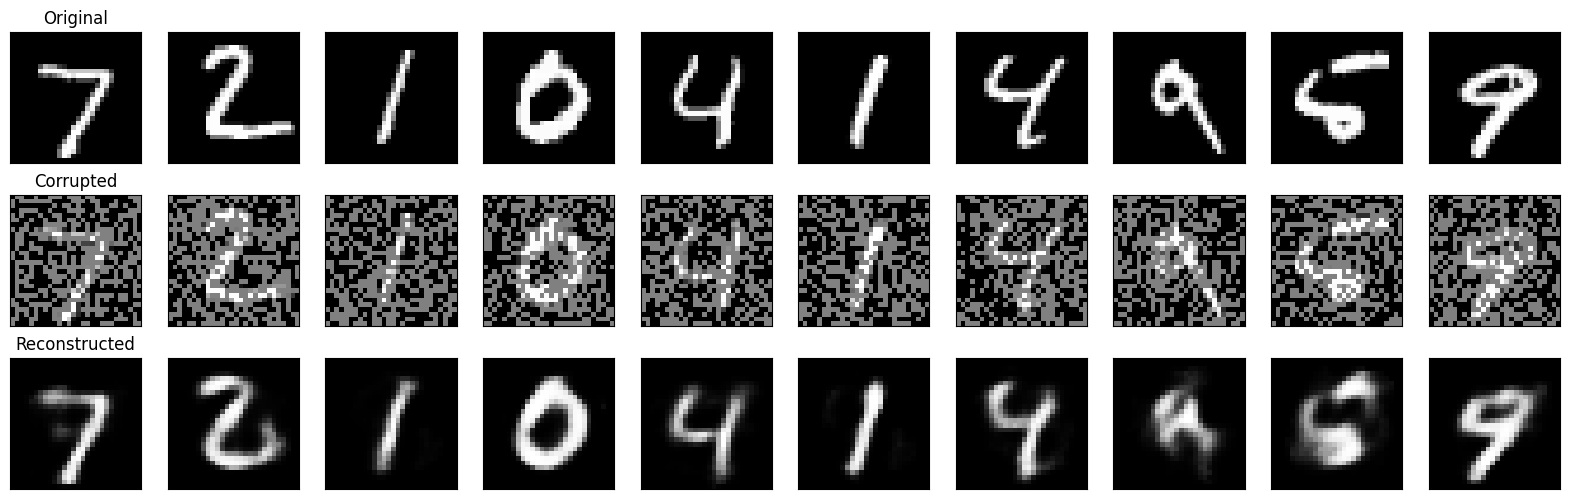

In [4]:
# Predict on the corrupted test images
y_pred = autoencoder.predict(masked_x_test)

# Visualize the results (Original, Corrupted, Restored)
n = 10  # Number of digits to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original (clean)
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(norm_x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: ax.set_title("Original")

    # Display corrupted (input)
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(masked_x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: ax.set_title("Corrupted")

    # Display reconstruction (predicted)
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(y_pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: ax.set_title("Reconstructed")
plt.show()

---

## 4.2 Convolutional Neural Networks (CNNs)

CNNs are specialized networks for processing grid-like data, such as images. Unlike FCNs, they use **convolution** and **pooling** layers. This allows them to:
* **Preserve spatial information:** They look at 2D patches, not just flattened vectors.
* **Be parameter efficient:** A single filter (kernel) is shared across the entire image, learning to detect the same feature (e.g., an edge) everywhere.

Our task is to build a CNN to classify images from the **CIFAR-10 dataset**.

### 4.2.1 Understanding the Data (CIFAR-10)

In [5]:
import tensorflow_datasets as tfds

# Load the CIFAR-10 dataset using tfds
data = tfds.load('cifar10')

# Define a formatting function
def format_data(x, depth=10):
    # Cast image to float32 and normalize to [0, 1]
    image = tf.cast(x["image"], 'float32') / 255.0
    # One-hot encode the label
    label = tf.one_hot(x["label"], depth=depth)
    return image, label

# Create the tf.data pipeline
batch_size = 32
tr_data = data["train"].map(lambda x: format_data(x, depth=10)).batch(batch_size)
ts_data = data["test"].map(lambda x: format_data(x, depth=10)).batch(batch_size)

# Inspect a batch
for images, labels in tr_data.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.T96GCX_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.T96GCX_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
Batch of images shape: (32, 32, 32, 3)
Batch of labels shape: (32, 10)


### 4.2.2 Implementing the Network

This CNN architecture (based on Listing 4.3) interleaves `Conv2D` and `MaxPool2D` layers to progressively reduce the spatial dimensions (height, width) while increasing the feature depth (channels). The `Flatten` layer converts the final 3D feature map into a 1D vector for the final `Dense` classification layers.

In [6]:
K_.clear_session()

# Define the CNN model
cnn = models.Sequential([
    # Input shape is (32, 32, 3)
    layers.Conv2D(filters=16, kernel_size=(3,3), strides=(2,2), activation='relu',
                  padding='same', input_shape=(32,32,3)),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'),

    # Flatten the 3D output to 1D for the Dense layers
    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax') # 10 classes
])

# Compile the model
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,330 (157.54 KB)

 Trainable params: 40,330 (157.54 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train the CNN
print("Training CNN...")
history_cnn = cnn.fit(tr_data, epochs=25, validation_data=ts_data)
print("Training complete.")

Training CNN...
Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - acc: 0.3111 - loss: 1.8706 - val_acc: 0.4776 - val_loss: 1.4506
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - acc: 0.5020 - loss: 1.3865 - val_acc: 0.5529 - val_loss: 1.2482
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - acc: 0.5629 - loss: 1.2251 - val_acc: 0.5906 - val_loss: 1.1455
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - acc: 0.6014 - loss: 1.1264 - val_acc: 0.6137 - val_loss: 1.1046
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - acc: 0.6254 - loss: 1.0609 - val_acc: 0.6228 - val_loss: 1.0744
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - acc: 0.6435 - loss: 1.0104 - val_acc: 0.6338 - val_loss: 1.0518
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - acc: 0.6595 - loss: 0.9687 - val_acc: 0.6440 - val_loss: 1.0214
Epoch 8/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - acc: 0.6718 - loss: 0.9358 - val_acc: 0.6493 - val_loss: 1.0074
Epoch 9/

---

## 4.3 Recurrent Neural Networks (RNNs)

RNNs are designed for sequential data, like time series or text. Unlike FCNs or CNNs, RNNs have a **"memory"** (or hidden state) that is passed from one time step to the next. This allows the network's prediction at the current time step to be influenced by all previous time steps.

Our task is to predict future CO2 concentration levels based on past data.

### 4.3.1 Understanding the Data (CO2 Time Series)

In [8]:
import pandas as pd
import requests
import os

# Define the data download function
def download_data():
    save_dir = "data"
    save_path = os.path.join(save_dir, 'co2-mm-gl.csv')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not os.path.exists(save_path):
        print("Downloading CO2 data...")
        url = "https://datahub.io/core/co2-ppm/r/co2-mm-gl.csv"
        r = requests.get(url)
        with open(save_path, 'wb') as f:
            f.write(r.content)
        print("Download complete.")
    else:
        print("CO2 data already exists.")
    return save_path

save_path = download_data()

# Load data with pandas
data = pd.read_csv(save_path)
data = data.set_index('Date')

# The data has an upward trend, which is hard for a model to learn.
# We make it 'stationary' by calculating the difference from the previous month.
data["Average Diff"] = data["Average"] - data["Average"].shift(1)
# Fill the first NaN value
data = data.fillna(method='bfill')

print("Data with 'Average Diff':")
print(data.head())

Download complete.
Data with 'Average Diff':
        Decimal Date  Average  Trend  Average Diff
Date                                              
336.56          0.11   335.92   0.09          0.33
337.29          0.09   336.25   0.09          0.33
337.88          0.11   336.51   0.09          0.26
338.32          0.13   336.72   0.10          0.21
338.26          0.04   336.71   0.10         -0.01


/tmp/ipython-input-2164144412.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill')


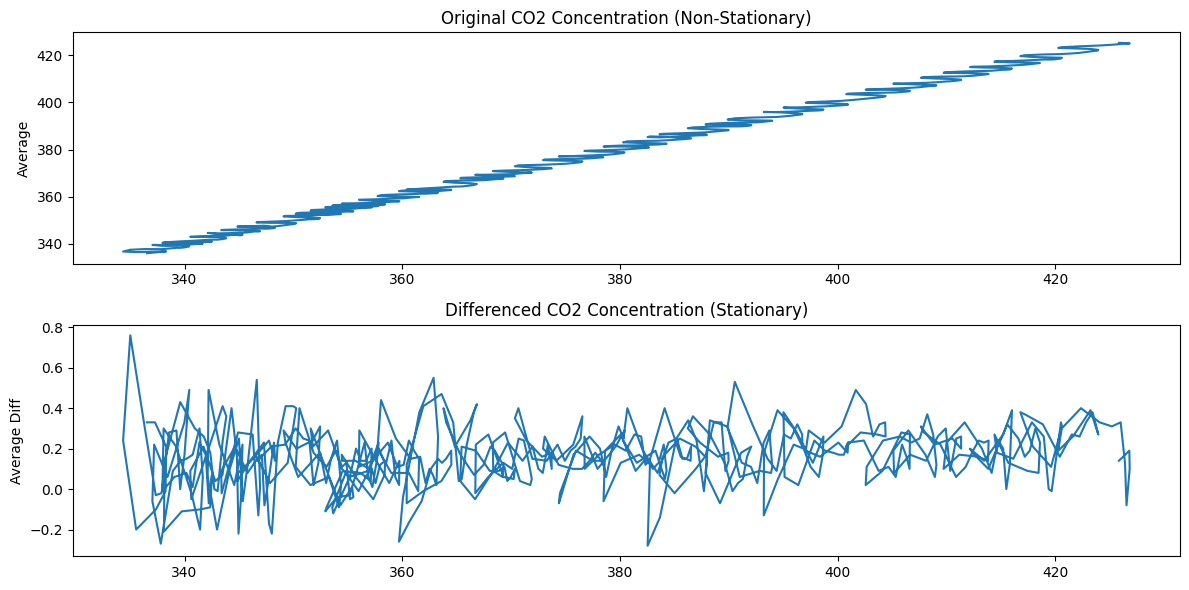

In [9]:
# Plot the original vs. differenced data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(data["Average"])
plt.title("Original CO2 Concentration (Non-Stationary)")
plt.ylabel("Average")

plt.subplot(2, 1, 2)
plt.plot(data["Average Diff"])
plt.title("Differenced CO2 Concentration (Stationary)")
plt.ylabel("Average Diff")
plt.tight_layout()
plt.show()

In [10]:
# This function creates sequences of data.
# x = 12 past values, y = 13th value
# We use the corrected version from Listing 4.5
def generate_data(co2_arr, n_seq):
    x, y = [], []
    for i in range(co2_arr.shape[0] - n_seq):
        x.append(co2_arr[i:i + n_seq - 1])
        y.append(co2_arr[i + n_seq - 1:i + n_seq])

    # Reshape x to [batch, timesteps, features] for the RNN layer
    x = np.array(x).reshape(-1, n_seq - 1, 1)
    y = np.array(y)
    return x, y

# We'll use 12 months to predict the 13th (n_seq = 13)
n_seq = 13
x_rnn, y_rnn = generate_data(data["Average Diff"].values, n_seq=n_seq)

print(f"Generated x shape: {x_rnn.shape}")
print(f"Generated y shape: {y_rnn.shape}")

Generated x shape: (545, 12, 1)
Generated y shape: (545, 1)


### 4.3.2 Implementing the Model

We use a `SimpleRNN` layer. This layer requires its input to be 3D: `(batch_size, timesteps, features)`. This is why we reshaped our data to `(429, 12, 1)`.

In [11]:
K_.clear_session()

# Define the RNN model
rnn = models.Sequential([
    # input_shape is (timesteps, features)
    layers.SimpleRNN(64, input_shape=(n_seq - 1, 1)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1) # Output a single value (the next 'Average Diff')
])

# Compile for regression using Mean Squared Error (MSE)
rnn.compile(loss='mse', optimizer='adam')
rnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,449 (33.00 KB)

 Trainable params: 8,449 (33.00 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the RNN
print("Training RNN...")
history_rnn = rnn.fit(x_rnn, y_rnn, shuffle=True, batch_size=64, epochs=25)
print("Training complete.")

Training RNN...
Epoch 1/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0341
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0160 
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0135 
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0115 
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114 
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0109 
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0112
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0103 
Epoch 9/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0107 
Epoch 10/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0104 
Epoch 11/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0104 
Epoch 12/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0103 
Epoch 13/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0097 
Epoch 14/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0099 
Epoch 15/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0092 
Epoch 16/25
9/9 ━━━

### 4.3.3 Predicting Future CO2 Values

To predict the future, we use the model recursively. We take the last 12 known `Average Diff` values, predict the next value, add that prediction to our history, and repeat the process for 60 months (5 years).

In [13]:
# Get the last 12 diffs from the original data as the starting point
history = data["Average Diff"].values[-12:].reshape(1, -1, 1)

# Get the very last *actual* CO2 value to build our predictions upon
prev_true = data["Average"].values[-1]

true_vals = [] # List to hold the predicted *absolute* CO2 values

print("Predicting future values...")
# Predict 60 steps (5 years) into the future
for i in range(60):
    # Predict the next diff (p_diff)
    p_diff = rnn.predict(history).reshape(1, -1, 1)

    # Update the history: drop the oldest value, append the newest prediction
    history = np.concatenate((history[:, 1:, :], p_diff), axis=1)

    # Calculate the absolute CO2 value by adding the predicted diff to the last true value
    predicted_val = prev_true + p_diff[0, 0, 0]
    true_vals.append(predicted_val)

    # Update prev_true for the next loop
    prev_true = predicted_val

print("Prediction complete.")

Predicting future values...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━

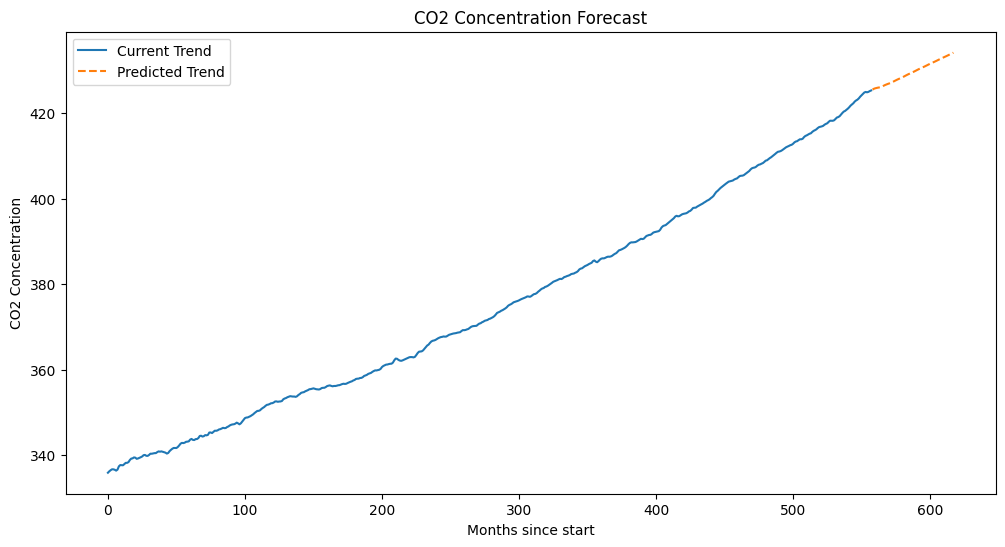

In [14]:
# Plot the original data and the future predictions
plt.figure(figsize=(12, 6))
plt.plot(data["Average"].values, label="Current Trend")

# Create an index for the predicted values, starting from the end of the original data
predict_index = range(len(data), len(data) + 60)
plt.plot(predict_index, true_vals, label="Predicted Trend", linestyle='--')

plt.title("CO2 Concentration Forecast")
plt.ylabel("CO2 Concentration")
plt.xlabel("Months since start")
plt.legend()
plt.show()